In [2]:
import tensorflow as tf
tf.__version__

'1.15.5'

In [3]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

#### Get the data!

In [3]:
#!wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip

#!wget http://grebvm2.epfl.ch/lin/food/Food-5K.zip

!wget http://rocketpanther.com/datascience/Food-5K.zip

--2021-08-29 23:28:33--  http://rocketpanther.com/datascience/Food-5K.zip
Resolving rocketpanther.com (rocketpanther.com)... 173.233.95.176
Connecting to rocketpanther.com (rocketpanther.com)|173.233.95.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446963301 (426M) [application/zip]
Saving to: 'Food-5K.zip.1'

Food-5K.zip.1       100%[===================>] 426.26M  54.2MB/s    in 8.0s    

2021-08-29 23:28:41 (53.5 MB/s) - 'Food-5K.zip.1' saved [446963301/446963301]



In [4]:
import zipfile

with zipfile.ZipFile('Food-5K.zip', "r") as z:
    z.extractall('/home')

In [5]:
!ls evaluation/food

0.jpg	 149.jpg  2.jpg    25.jpg   30.jpg   350.jpg  400.jpg  451.jpg	52.jpg
1.jpg	 15.jpg   20.jpg   250.jpg  300.jpg  351.jpg  401.jpg  452.jpg	53.jpg
10.jpg	 150.jpg  200.jpg  251.jpg  301.jpg  352.jpg  402.jpg  453.jpg	54.jpg
100.jpg  151.jpg  201.jpg  252.jpg  302.jpg  353.jpg  403.jpg  454.jpg	55.jpg
101.jpg  152.jpg  202.jpg  253.jpg  303.jpg  354.jpg  404.jpg  455.jpg	56.jpg
102.jpg  153.jpg  203.jpg  254.jpg  304.jpg  355.jpg  405.jpg  456.jpg	57.jpg
103.jpg  154.jpg  204.jpg  255.jpg  305.jpg  356.jpg  406.jpg  457.jpg	58.jpg
104.jpg  155.jpg  205.jpg  256.jpg  306.jpg  357.jpg  407.jpg  458.jpg	59.jpg
105.jpg  156.jpg  206.jpg  257.jpg  307.jpg  358.jpg  408.jpg  459.jpg	6.jpg
106.jpg  157.jpg  207.jpg  258.jpg  308.jpg  359.jpg  409.jpg  46.jpg	60.jpg
107.jpg  158.jpg  208.jpg  259.jpg  309.jpg  36.jpg   41.jpg   460.jpg	61.jpg
108.jpg  159.jpg  209.jpg  26.jpg   31.jpg   360.jpg  410.jpg  461.jpg	62.jpg
109.jpg  16.jpg   21.jpg   260.jpg  310.jpg  361.jpg  411.jpg  462.jpg	

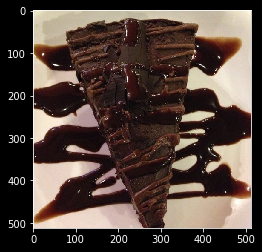

In [31]:
plt.style.use('dark_background')
plt.imshow(image.load_img('data/test/food/297.jpg'))
plt.show()

In [7]:
!mkdir data 
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [9]:
!mv training/food/*.jpg data/train/food
!mv training/non_food/*.jpg data/train/nonfood
!mv evaluation/food/*.jpg data/test/food
!mv evaluation/non_food/*.jpg data/test/nonfood

In [4]:
train_path = 'data/train'
valid_path = 'data/test'

In [5]:
#standardize size
IMAGE_SIZE = [200,200]

In [6]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [7]:
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

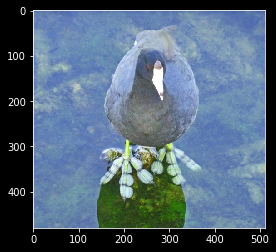

In [10]:
plt.style.use('dark_background')
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

### Load pretrained model

In [11]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

In [12]:
#freeze pretrained weights
ptm.trainable=False

In [13]:
#map data into feature vectors
#keras image data generator returns one-hot encoded classes

K = len(folders)
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [14]:
#create model 
model = Model(inputs=ptm.input, outputs=x)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [16]:
#create instance of ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [17]:
batch_size = 128

#create generators
train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [19]:
#fit this thang!
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=3,
    #steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    #validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
    steps_per_epoch=24,
    validation_steps=8,
)

Epoch 1/3


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[128,64,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block1_conv1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/acc/Identity/_201]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[128,64,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block1_conv1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

8